Устоновка библиотек. Download framework.

In [1]:
!pip install tqdm
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 1.2 MB/s eta 0:00:00


Импорт библиотек. Import framework.

In [2]:
import keras
import time
import dill

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2DTranspose, Conv2D, BatchNormalization, LeakyReLU, Activation, UpSampling2D, ZeroPadding2D, MaxPooling2D
from keras.layers.reshaping.reshape import Reshape

from skimage import io

from datetime import datetime
from PIL import Image

Подключение google drive к проекту. Connecting google drive to project.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
arts = 2047 # Кол. нужных изображений. Quantity necessary image.
image_dataset = [] # Массив для векторизованных изображений. Array for vectorized image.

В этой части кода мы изменяем размер изображения 64х64 и после идет их векторизация и запись в массив. 

In this part of the code, we resize the image to 64x64 and after that they are vectorized and written to an array.

In [5]:
from tqdm import tqdm

shapes = (64, 64) # Размерность изображений. Shape image.


# Функция для изменения изображения. Function to change the image.
def image_resize(image: str, shape: list, name_image: str) -> None:
  image = Image.open(image)
  new_image = image.resize(shape)
  new_image.save(f'{name_image}')

for i in tqdm(range(1, arts)):
  try:
    image_resize(f'/content/drive/MyDrive/dataset_090/anime ({i}).jpg', shapes, f'./dataset/anime ({i}).jpg')
    image_dataset.append(io.imread(f'/content/dataset/anime ({i}).jpg'))
  except:
    print('Not found')

100%|██████████| 2046/2046 [18:20<00:00,  1.86it/s]


Здесь приводиться нормализация каждого изображения. Это нужно для того чтобы нейросети было проще учиться на данных.

Here is the normalization of each image. This is necessary in order to make it easier for the neural network to learn from the data.

In [6]:
# В части с i.astype('float32')[:, :, :3]. 
# Тут мы отделяем до тройка. Это нужно для того чтобы в массиве все изображения были одинаковыми и легче было бы анализировать данные нейросети.

# In the part with i.astype('float32')[:, :, :3].
# Here we separate to triple. This is necessary so that all images in the array are the same and it would be easier to analyze the neural network data.

image = np.array([i.astype('float32')[:, :, :3] / 127.5 -1 for i in image_dataset])

Перемножаем размеры фотографий для того чтобы научить генератор рисовать картинки на неизвестных для него данных. 

We multiply the sizes of photos in order to teach the generator to draw pictures on unknown data.

In [7]:
image_ = image.reshape((image.shape[0], shapes[0]*shapes[1]*image.shape[3]))

Создаем генератор на архитектуре VAE(variational autoencoder).

We create a generator based on the VAE (variational autoencoder) architecture.

Используем вначале ***Dense*** слой для того чтобы ввести наши данные. 
После идет изменение изображения обратно ***64x64x3***. 

***MaxPooling2D*** нужен для уменшения изображения тем самым encoder быстрее обрабатывает изображение. 

***Conv2D*** нужен для того чтобы свернуть данные и взять определенные признаки изображения.

***BatchNormalization*** нужен в для ускорения и повышения стабильного обучения.

***LeakyReLU*** - это функция активации и он нужен для того чтобы небыло вымывания градиента.

***Dropout*** нужен для предотвращения переобучения.

***Flatten*** выравнивает изображение.

***Dense(32×32×3)*** это выходной слой

***Conv2DTranspose*** то же самое что и ***Conv2D***, но при условии того что он переобразовывает в обратную сторону.

***Selu*** - Это функция активации которая была предложена в 2017 году. Это расширенная версия ELU (Exponential Linear Units), но отличаеться тем что она автоматически настраивает слои для каждого слоя.

***UpSampling2D*** нужен для повышения размерности изображения.

***Conv2DTranspose(3)*** выводит изображение 64х64х3.

***Tanh*** функция активации для вывода изображения (то же что и sigmoid функция но более прямая по оси x=0 и медленее, но в этой модели намного лучше работает).

First use the ***Dense*** layer to enter our data. 
After goes the image change back ***64x64x3***. 

***MaxPooling2D*** is needed for image decrease thereby encoder faster image processing. 

***Conv2D*** are needed to collapse data and take certain image features.

***BatchNormalization*** is needed in order to accelerate and enhance stable learning.

***LeakyReLU***is an activation function and it is needed to avoid gradient leaching.

***Dropout*** is needed to prevent retraining.

***Flatten*** aligns the image.

***Dense(32 32 3)*** is the output layer

***Conv2DTranspose*** is the same as ***Conv2D****, but provided that it retransmits.

***Selu*** - this is the activation function that was proposed in 2017. It is an extended version of ELU (Exponential Linear Units), but differs in that it automatically adjusts layers for each layer.

***UpSampling2D*** are needed to increase the image dimension.

***Conv2DTranspose(3)*** output 64x64x3 image.

***Tanh*** image output activation function (same as sigmoid function but more straight on x=0 axis and slower, but in this model works much better).

In [8]:
class VAE(Model):
  def __init__(self):
    super(VAE, self).__init__()   
    self.encoder = tf.keras.Sequential([
      Dense(64*64*3, input_shape=(image_.shape[1], )),
      
      Reshape((64, 64, 3)),

      MaxPooling2D(2,padding="same", strides=2),
      Conv2D(256 ,kernel_size=8, padding='same'),
      BatchNormalization(momentum=.8),
      LeakyReLU(.2),
      Dropout(.25),
     
      MaxPooling2D(2,padding="same", strides=1),
      Conv2D(128 ,kernel_size=6, padding='same'),
      BatchNormalization(momentum=.8),
      LeakyReLU(.2),
      Dropout(.25),
      
      MaxPooling2D(2,padding="same", strides=1),
      Conv2D(64 ,kernel_size=6, padding='same'),
      BatchNormalization(momentum=.8),
      LeakyReLU(.2),
      Dropout(.25),

      MaxPooling2D(2,padding="same", strides=1),
      Conv2D(32 ,kernel_size=6, padding='same'),
      BatchNormalization(momentum=.8),
      LeakyReLU(.2),
      Dropout(.25),
      
      Flatten(),
      Dense(32*32*3)
      ])
    self.decoder = tf.keras.Sequential([
      Dense(32*32*3),
      Reshape((32, 32, 3)),

      Conv2DTranspose(32, kernel_size=6, padding='same'),  
      BatchNormalization(momentum=.8),
      Activation('selu'),   
      Dropout(.25),
      
      Conv2DTranspose(64, kernel_size=6, padding='same'),
      BatchNormalization(momentum=.8),
      Activation('selu'),
      Dropout(.25),
      
      Conv2DTranspose(128, kernel_size=6, padding='same'),  
      BatchNormalization(momentum=.8),
      Activation('selu'),
      Dropout(.25),
      
      UpSampling2D(),
      Conv2DTranspose(256, kernel_size=6, padding='same'),
      BatchNormalization(momentum=.8),
      Activation('selu'),
      Dropout(.25),
      
      Conv2DTranspose(3, kernel_size=8, padding='same'),
      Activation('tanh')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
vae = VAE()

In [9]:
vae.build((image_.shape[0], image_.shape[1])) # Собираем генератор. Build generator.

In [10]:
vae.summary() # Окончательная версия. Final version.

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3072)              253273440 
                                                                 
 sequential_1 (Sequential)   (2046, 64, 64, 3)         11043555  
                                                                 
Total params: 264,316,995
Trainable params: 264,315,075
Non-trainable params: 1,920
_________________________________________________________________


Тестовые изображение.

Test image.

In [11]:
image_resize(f'/content/drive/MyDrive/dataset_090/anime ({arts}).jpg', shapes, 'anime_test.jpg')
test = np.array([io.imread('anime_test.jpg').astype('float32') / 127.5 - 1]).reshape((1, 64*64*3))

Проверка на рабочию способность генератора.

Test for generator performance.

In [12]:
noise = tf.random.normal([1, image_.shape[1]]) # Выдаем рандомное изображение. Output a random image. 

imgs = vae(noise).numpy()

Показываем результат теста.

Show the test result.

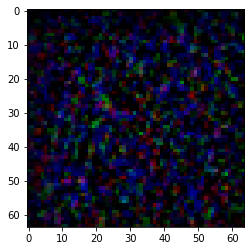

In [13]:
plt.imshow(imgs[0])
plt.show()


***ZeroPadding2D*** - cлой с нулевым заполнением для двумерного входного сигнала.

***Sigmoid*** - это функция активации которая нужна для сглаживания вывода данных.


***ZeroPadding2D*** is with zero-fill for two-dimensional input signal.

***Sigmoid*** is an activation function that is needed to smooth output.

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, 5, strides=2, padding='same',
                                     input_shape=(shapes[0], shapes[1], 3)))
    model.add(BatchNormalization(momentum=.8))    
    model.add(LeakyReLU(alpha=.2))
    
    model.add(Dropout(.25))

    model.add(Conv2D(64, 3, padding='same', strides=2))
    model.add(ZeroPadding2D(padding=((0,1), (0,1))))
    model.add(BatchNormalization(momentum=.8))
    model.add(LeakyReLU(alpha=.2))
    model.add(Dropout(.25))

    model.add(Conv2D(128, 3, padding='same', strides=(2, 2)))
    model.add(BatchNormalization(momentum=.8))
    model.add(LeakyReLU(alpha=.2))
    model.add(Dropout(.25))

    model.add(Conv2D(256, 3, padding='same'))
    model.add(BatchNormalization(momentum=.8))
    model.add(LeakyReLU(alpha=.2))
    model.add(Dropout(.25))

    model.add(Conv2D(512, 3, padding='same'))
    model.add(BatchNormalization(momentum=.8))
    model.add(LeakyReLU(alpha=.2))
    model.add(Dropout(.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = make_discriminator_model()

In [15]:
discriminator.summary() # Окончательная версия. Final version.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                  

In [16]:
discriminator(imgs) # Тест дискриминатора. Discriminator test.

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50494844]], dtype=float32)>

***BinaryCrossentropy*** отличная функция потерь которая хорошо показывает себя на практике.

***Adam*** хорошый оптимизатор который в большенстве случаев помогает с обучением модели.

***BinaryCrossentropy*** is an excellent loss function that has proven itself well in practice.

***Adam*** is a good optimizer which in most cases helps with model learning.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, .5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Это функция нужна для того чтобы обучать дискриминатор различать фальшивые изображения от настоящих.
# This function is needed to teach the discriminant to distinguish fake images from real ones.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Это функция нужна для того чтобы обучить генератор рисовать картинки так чтобы дискриминатор не смог отличить от настоящих изображений. 
# This function is needed to train the generator to draw pictures so that the discriminator can not distinguish from real pictures. 
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
# Генерирует готовое изображение и сохраняет его.
# Generates a finished image and saves it.
def generate_and_save_images(model, epoch, test_input):
  model_ = model(test_input).numpy()

  plt.imshow(model_[0])
  plt.axis('off')

  plt.savefig('./image/image_at_epoch_{:04d}.png'.format(epoch))

  plt.show()
  image_resize('./image/image_at_epoch_{:04d}.png'.format(epoch), (1012, 512), './image/image_at_epoch_{:04d}.png'.format(epoch))

Это функция для тренеровки дискриминатора и генератора.  

This is a function for coaching the discriminant and generator.  

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      img = vae(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(img, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, vae.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, vae.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

На этом этапе мы создаем функцию для полноценной тренеровки моделей и вывода, сохранения полученых в итоге изображений.

At this stage we create a function for full-fledged training of models and output, saving the resulting images.

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    gen_loss = []
    disc_loss = []

    for image_batch in tqdm(dataset):
      loss = train_step(np.array([image_batch]))
      
      gen_loss.append(loss[0])
      disc_loss = [loss[1]]

    gen_loss = sum(gen_loss) / len(gen_loss)
    disc_loss = sum(disc_loss) / len(disc_loss)

    generate_and_save_images(vae,
                             epoch + 1,
                             test)

    print ('Time for epoch {} is {} sec\ngen loss - {}, disc loss - {}'.format(epoch + 1, time.time()-start, gen_loss, disc_loss))

  generate_and_save_images(vae,
                            epochs,
                          test)

  
  model = {'vae': vae, 
            'discriminator': discriminator}

  dill.dump(model, open('Alpha-Model.pkl', 'wb'))

Тренеруем модели в течении 81 эпохи.

Coaching models for 81 epochs.

100%|██████████| 2046/2046 [02:36<00:00, 13.04it/s]


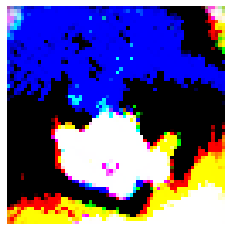

Time for epoch 1 is 157.2519998550415 sec
gen loss - 3.4330408573150635, disc loss - 0.26051631569862366


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


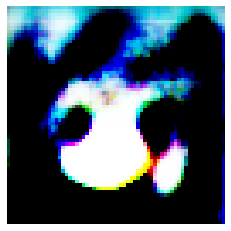

Time for epoch 2 is 143.7498004436493 sec
gen loss - 4.735845565795898, disc loss - 0.7315314412117004


100%|██████████| 2046/2046 [02:23<00:00, 14.25it/s]


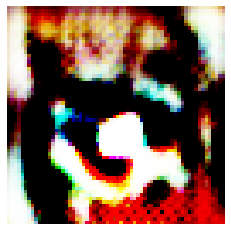

Time for epoch 3 is 143.9089744091034 sec
gen loss - 2.9447824954986572, disc loss - 0.2560795545578003


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


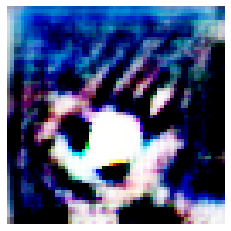

Time for epoch 4 is 143.69704699516296 sec
gen loss - 3.579925298690796, disc loss - 0.3867555260658264


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


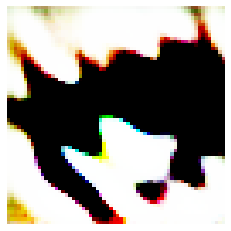

Time for epoch 5 is 143.60836243629456 sec
gen loss - 3.1633615493774414, disc loss - 0.1364869624376297


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


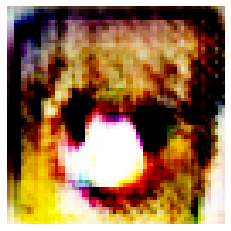

Time for epoch 6 is 143.5974040031433 sec
gen loss - 5.667060375213623, disc loss - 0.05621432140469551


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


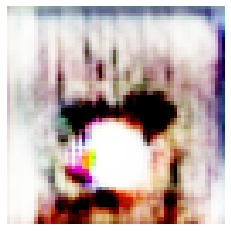

Time for epoch 7 is 143.77209210395813 sec
gen loss - 3.985490560531616, disc loss - 0.07340700924396515


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


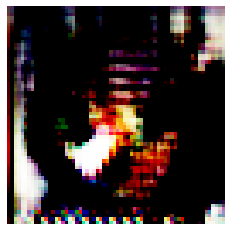

Time for epoch 8 is 143.5353934764862 sec
gen loss - 4.502181529998779, disc loss - 0.5581551790237427


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


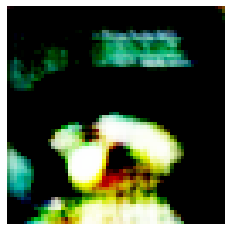

Time for epoch 9 is 143.51635885238647 sec
gen loss - 3.912001132965088, disc loss - 0.027431756258010864


100%|██████████| 2046/2046 [02:23<00:00, 14.26it/s]


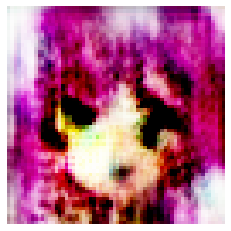

Time for epoch 10 is 143.75281953811646 sec
gen loss - 3.6421101093292236, disc loss - 0.4523885250091553


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


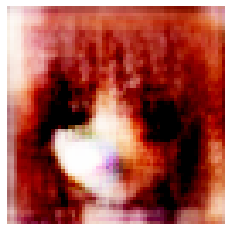

Time for epoch 11 is 143.54580354690552 sec
gen loss - 3.5976457595825195, disc loss - 0.17988938093185425


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


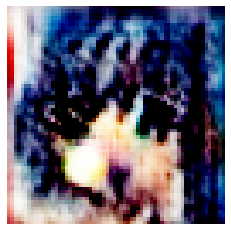

Time for epoch 12 is 143.60555720329285 sec
gen loss - 3.5059452056884766, disc loss - 1.1117628812789917


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


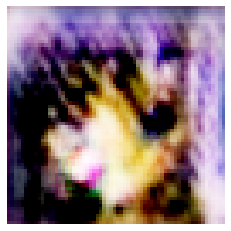

Time for epoch 13 is 143.72293329238892 sec
gen loss - 3.4846503734588623, disc loss - 2.3708786964416504


100%|██████████| 2046/2046 [02:23<00:00, 14.23it/s]


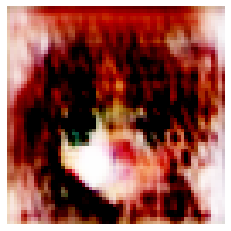

Time for epoch 14 is 144.1472134590149 sec
gen loss - 3.3786685466766357, disc loss - 0.8917564749717712


100%|██████████| 2046/2046 [02:23<00:00, 14.21it/s]


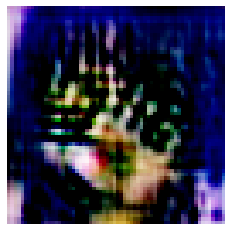

Time for epoch 15 is 144.2950301170349 sec
gen loss - 3.320841073989868, disc loss - 0.26860347390174866


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


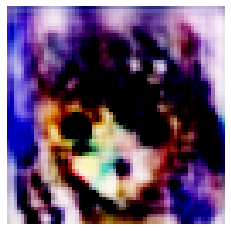

Time for epoch 16 is 143.774329662323 sec
gen loss - 3.4789769649505615, disc loss - 0.15442924201488495


100%|██████████| 2046/2046 [02:23<00:00, 14.23it/s]


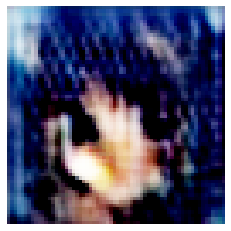

Time for epoch 17 is 144.11743712425232 sec
gen loss - 3.6033518314361572, disc loss - 0.015669023618102074


100%|██████████| 2046/2046 [02:23<00:00, 14.24it/s]


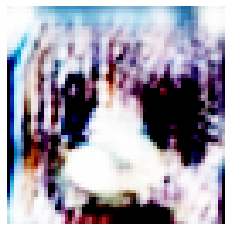

Time for epoch 18 is 143.99716234207153 sec
gen loss - 3.9692368507385254, disc loss - 0.8305507898330688


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


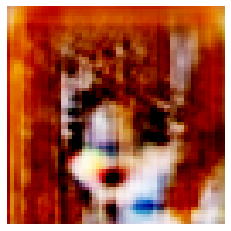

Time for epoch 19 is 143.73533821105957 sec
gen loss - 4.231192111968994, disc loss - 0.9800100922584534


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


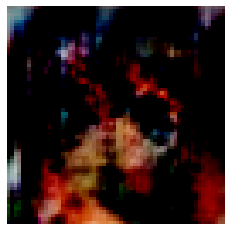

Time for epoch 20 is 143.71329188346863 sec
gen loss - 3.0102646350860596, disc loss - 0.03809760883450508


100%|██████████| 2046/2046 [02:23<00:00, 14.26it/s]


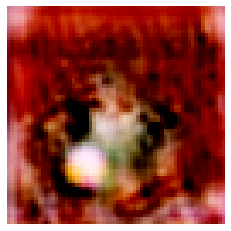

Time for epoch 21 is 143.8331437110901 sec
gen loss - 2.6730763912200928, disc loss - 0.07818655669689178


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


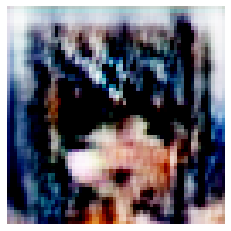

Time for epoch 22 is 143.59002351760864 sec
gen loss - 3.5380544662475586, disc loss - 0.010354016907513142


100%|██████████| 2046/2046 [02:23<00:00, 14.25it/s]


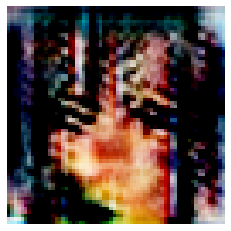

Time for epoch 23 is 143.89510464668274 sec
gen loss - 3.2955386638641357, disc loss - 0.6740036606788635


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


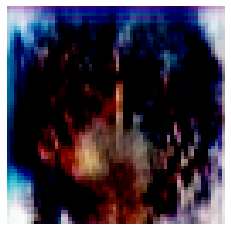

Time for epoch 24 is 143.52166152000427 sec
gen loss - 3.124176502227783, disc loss - 1.0092411041259766


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


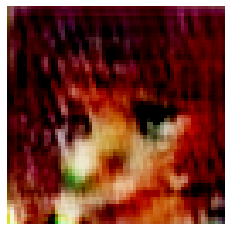

Time for epoch 25 is 143.3759002685547 sec
gen loss - 3.3261282444000244, disc loss - 0.024024298414587975


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


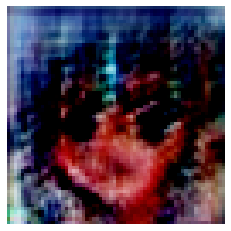

Time for epoch 26 is 143.48409605026245 sec
gen loss - 3.1936347484588623, disc loss - 0.0411231704056263


100%|██████████| 2046/2046 [02:22<00:00, 14.31it/s]


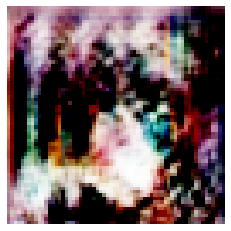

Time for epoch 27 is 143.33017349243164 sec
gen loss - 3.174628734588623, disc loss - 0.13436400890350342


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


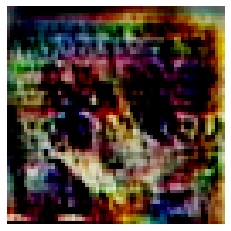

Time for epoch 28 is 143.65022325515747 sec
gen loss - 3.103837490081787, disc loss - 0.007424400188028812


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


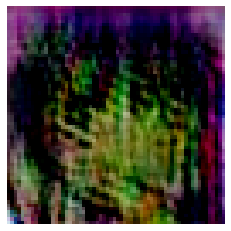

Time for epoch 29 is 143.62348914146423 sec
gen loss - 3.1252245903015137, disc loss - 0.13059721887111664


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


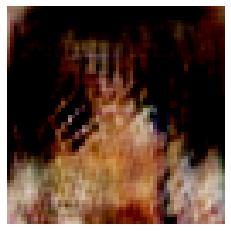

Time for epoch 30 is 143.5134356021881 sec
gen loss - 2.9604740142822266, disc loss - 0.531035840511322


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


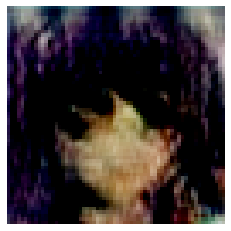

Time for epoch 31 is 143.43326878547668 sec
gen loss - 2.2280523777008057, disc loss - 0.6082488298416138


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


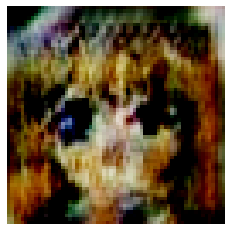

Time for epoch 32 is 143.57516860961914 sec
gen loss - 2.3003242015838623, disc loss - 2.1180336475372314


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


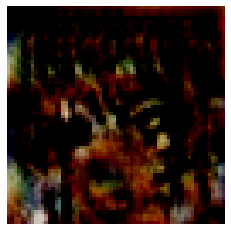

Time for epoch 33 is 143.49507117271423 sec
gen loss - 2.34281063079834, disc loss - 1.3289806842803955


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


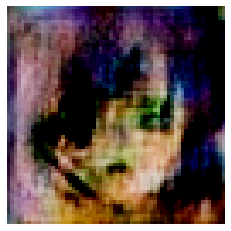

Time for epoch 34 is 143.4818570613861 sec
gen loss - 2.1964597702026367, disc loss - 0.7498829364776611


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


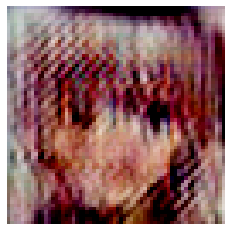

Time for epoch 35 is 143.59645199775696 sec
gen loss - 2.1555919647216797, disc loss - 0.22843754291534424


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


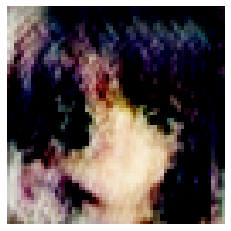

Time for epoch 36 is 143.55495953559875 sec
gen loss - 2.1490559577941895, disc loss - 0.6166852116584778


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


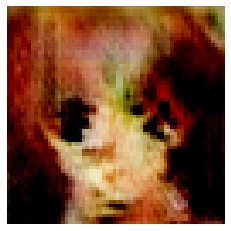

Time for epoch 37 is 143.50907731056213 sec
gen loss - 2.124586343765259, disc loss - 0.2185487449169159


100%|██████████| 2046/2046 [02:23<00:00, 14.23it/s]


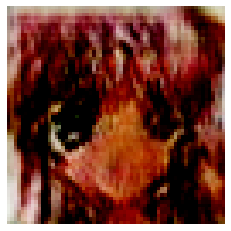

Time for epoch 38 is 144.21222400665283 sec
gen loss - 2.1895320415496826, disc loss - 0.7194274663925171


100%|██████████| 2046/2046 [02:23<00:00, 14.24it/s]


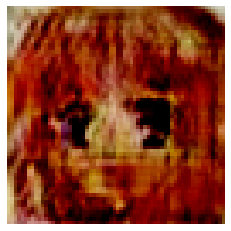

Time for epoch 39 is 144.02475786209106 sec
gen loss - 2.1274056434631348, disc loss - 0.19445542991161346


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


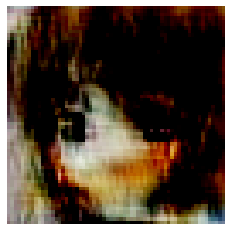

Time for epoch 40 is 143.69217348098755 sec
gen loss - 2.090085029602051, disc loss - 4.334462642669678


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


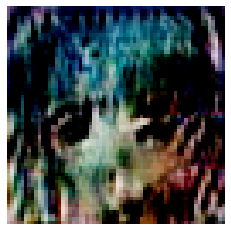

Time for epoch 41 is 143.55220913887024 sec
gen loss - 2.1243863105773926, disc loss - 0.3563591241836548


100%|██████████| 2046/2046 [02:23<00:00, 14.24it/s]


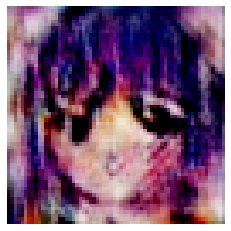

Time for epoch 42 is 143.98767066001892 sec
gen loss - 2.0542192459106445, disc loss - 0.2319323718547821


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


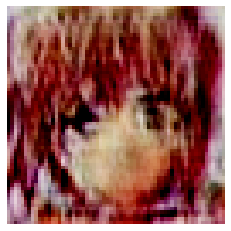

Time for epoch 43 is 143.7580783367157 sec
gen loss - 2.2018582820892334, disc loss - 0.162903293967247


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


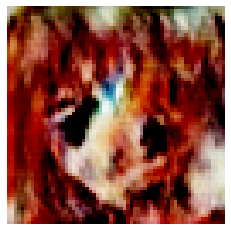

Time for epoch 44 is 143.67491269111633 sec
gen loss - 2.211268901824951, disc loss - 0.35692036151885986


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


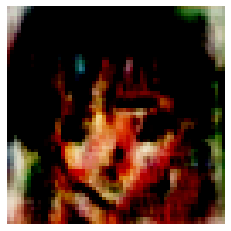

Time for epoch 45 is 143.53658318519592 sec
gen loss - 2.292919874191284, disc loss - 0.4045696258544922


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


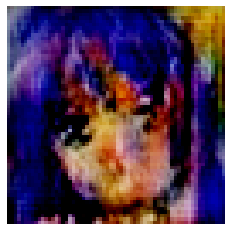

Time for epoch 46 is 143.74275994300842 sec
gen loss - 2.23756742477417, disc loss - 0.23481987416744232


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


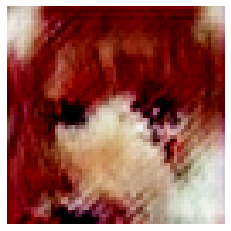

Time for epoch 47 is 143.67112612724304 sec
gen loss - 2.162017345428467, disc loss - 0.5001772046089172


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


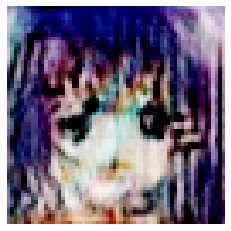

Time for epoch 48 is 143.57959127426147 sec
gen loss - 2.2264740467071533, disc loss - 0.3999471962451935


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


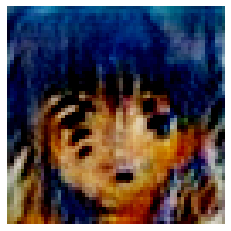

Time for epoch 49 is 143.5619559288025 sec
gen loss - 2.309246778488159, disc loss - 0.10770165175199509


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


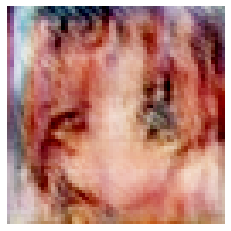

Time for epoch 50 is 143.64993500709534 sec
gen loss - 2.2964766025543213, disc loss - 0.6261255145072937


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


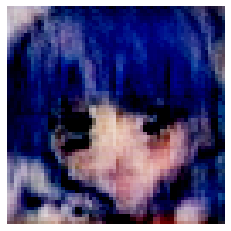

Time for epoch 51 is 143.49729681015015 sec
gen loss - 2.365985155105591, disc loss - 0.218520849943161


100%|██████████| 2046/2046 [02:22<00:00, 14.32it/s]


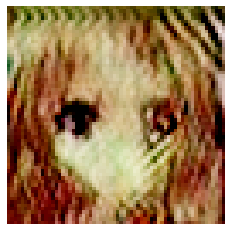

Time for epoch 52 is 143.2289080619812 sec
gen loss - 2.521376132965088, disc loss - 0.2740364074707031


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


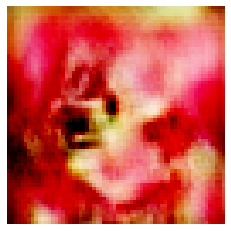

Time for epoch 53 is 143.4395592212677 sec
gen loss - 2.3845126628875732, disc loss - 1.5161619186401367


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


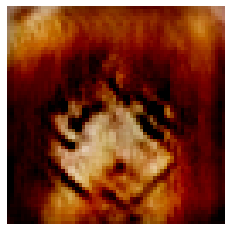

Time for epoch 54 is 143.49482321739197 sec
gen loss - 2.3260297775268555, disc loss - 0.5410683751106262


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


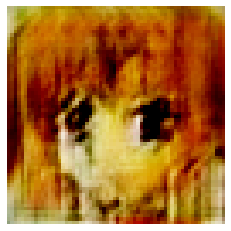

Time for epoch 55 is 143.39239954948425 sec
gen loss - 2.2443015575408936, disc loss - 0.21812960505485535


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


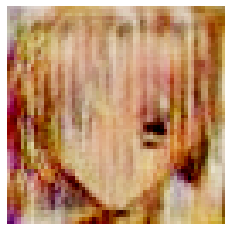

Time for epoch 56 is 143.45530462265015 sec
gen loss - 2.3752310276031494, disc loss - 0.7700657248497009


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


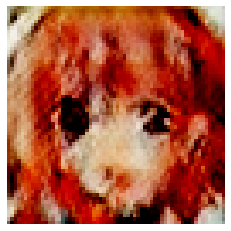

Time for epoch 57 is 143.5035116672516 sec
gen loss - 2.2699661254882812, disc loss - 0.20320165157318115


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


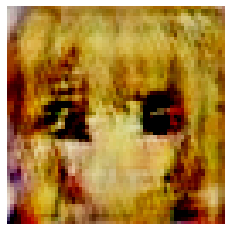

Time for epoch 58 is 143.45266962051392 sec
gen loss - 2.3269786834716797, disc loss - 1.119563102722168


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


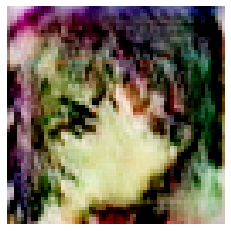

Time for epoch 59 is 143.46779131889343 sec
gen loss - 2.3177804946899414, disc loss - 1.8253179788589478


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


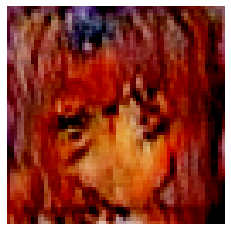

Time for epoch 60 is 143.4957013130188 sec
gen loss - 2.51768159866333, disc loss - 0.14871644973754883


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


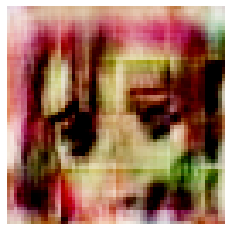

Time for epoch 61 is 143.5332646369934 sec
gen loss - 2.316694498062134, disc loss - 0.05078642815351486


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


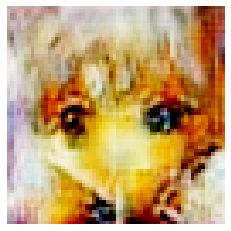

Time for epoch 62 is 143.46167016029358 sec
gen loss - 2.5267863273620605, disc loss - 0.1772361844778061


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


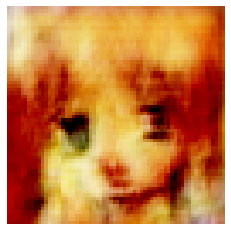

Time for epoch 63 is 143.68339037895203 sec
gen loss - 2.5136470794677734, disc loss - 0.11042876541614532


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


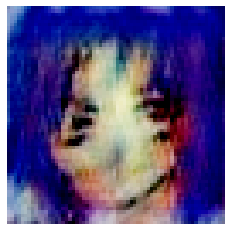

Time for epoch 64 is 143.45389795303345 sec
gen loss - 2.5397162437438965, disc loss - 0.05233112722635269


100%|██████████| 2046/2046 [02:22<00:00, 14.31it/s]


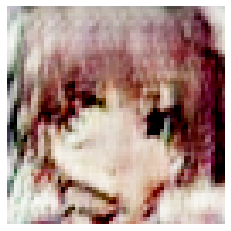

Time for epoch 65 is 143.35796236991882 sec
gen loss - 2.571160316467285, disc loss - 0.9454919695854187


100%|██████████| 2046/2046 [02:23<00:00, 14.30it/s]


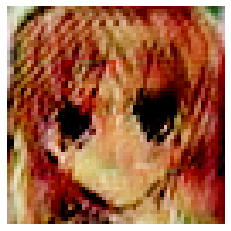

Time for epoch 66 is 143.46911001205444 sec
gen loss - 2.453495502471924, disc loss - 0.9434176683425903


100%|██████████| 2046/2046 [02:23<00:00, 14.24it/s]


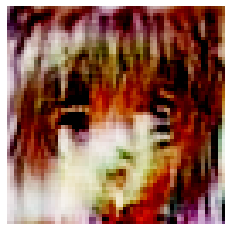

Time for epoch 67 is 144.02371954917908 sec
gen loss - 2.391355276107788, disc loss - 0.14847391843795776


100%|██████████| 2046/2046 [02:23<00:00, 14.23it/s]


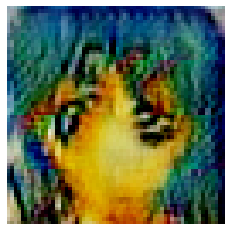

Time for epoch 68 is 144.14594864845276 sec
gen loss - 2.516918182373047, disc loss - 0.12251879274845123


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


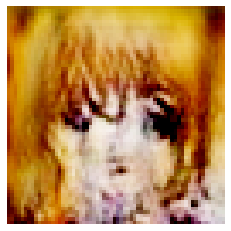

Time for epoch 69 is 143.72416925430298 sec
gen loss - 2.47861647605896, disc loss - 0.7618128061294556


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


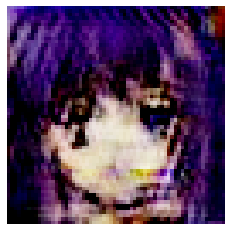

Time for epoch 70 is 143.5134859085083 sec
gen loss - 2.594897747039795, disc loss - 0.5867005586624146


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


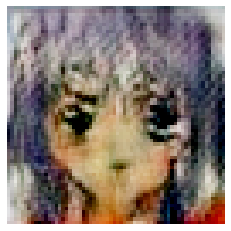

Time for epoch 71 is 143.58759140968323 sec
gen loss - 2.5306079387664795, disc loss - 0.5402863025665283


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


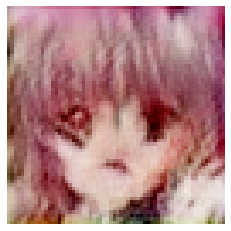

Time for epoch 72 is 143.75988292694092 sec
gen loss - 2.703171491622925, disc loss - 0.8634890913963318


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


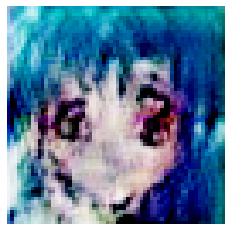

Time for epoch 73 is 143.72583556175232 sec
gen loss - 2.5229012966156006, disc loss - 0.03549980744719505


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


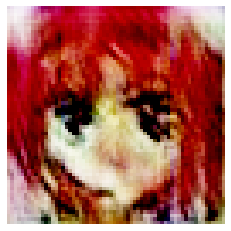

Time for epoch 74 is 143.60195350646973 sec
gen loss - 2.690354347229004, disc loss - 0.10775747150182724


100%|██████████| 2046/2046 [02:23<00:00, 14.26it/s]


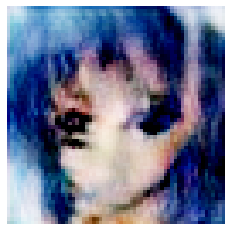

Time for epoch 75 is 143.78904914855957 sec
gen loss - 2.602097988128662, disc loss - 0.29565683007240295


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


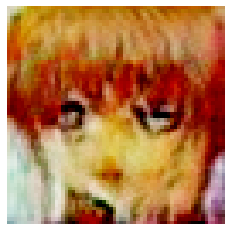

Time for epoch 76 is 143.73178100585938 sec
gen loss - 2.6831018924713135, disc loss - 0.4694705307483673


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


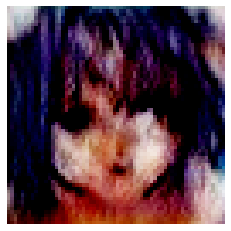

Time for epoch 77 is 143.76956415176392 sec
gen loss - 2.483447790145874, disc loss - 0.8097017407417297


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


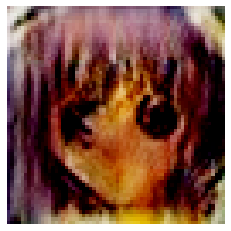

Time for epoch 78 is 143.57394886016846 sec
gen loss - 2.5764732360839844, disc loss - 0.11250746995210648


100%|██████████| 2046/2046 [02:23<00:00, 14.29it/s]


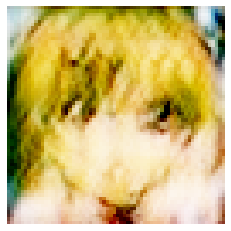

Time for epoch 79 is 143.50012516975403 sec
gen loss - 2.6954143047332764, disc loss - 0.06925497949123383


100%|██████████| 2046/2046 [02:23<00:00, 14.27it/s]


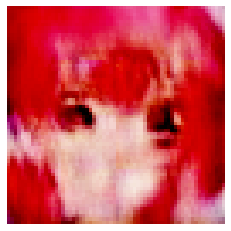

Time for epoch 80 is 143.71348237991333 sec
gen loss - 2.6816184520721436, disc loss - 0.15141721069812775


100%|██████████| 2046/2046 [02:23<00:00, 14.28it/s]


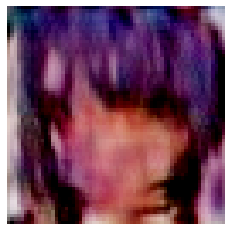

Time for epoch 81 is 143.59918928146362 sec
gen loss - 2.6310575008392334, disc loss - 0.03828807920217514


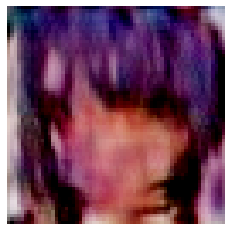

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...decoder
......layers
.........activation
............vars
.........activation_1
............vars
.........activation_2
............vars
.........activation_3
............vars
.........activation_4
............vars
.........batch_normalization
............vars
...............0
...............1
...............2
...............3
.........batch_normalization_1
............vars
...............0
...............1
...............2
...............3
.........batch_normalization_2
............vars
...............0
...............1
...............2
...............3
.........batch_normalization_3
............vars
...............0
...............1
...............2
...............3
.........conv2d_transpose
............vars
...............0
...............1
.........conv2d_transpose_1
............vars
...............0
...............1
.........conv2d_transpose_2
............vars
...............0
...............1
.........conv2d_tran

In [21]:
train(image, 81)